# Phishing Email Detection Model and Streamlit App
This is a personal project that i completed to start learning about natural language processing in the context of building predictive models, some feature engineering and building streamlit apps and dashboards. 

Data source: https://www.kaggle.com/datasets/subhajournal/phishingemails

## Outline:
1. ETL, dleaning text, encoding and initial plots
2. Define features and classification
3. Random Forest Model
4. Regression Model
5. XGBoost CLassifier
6. Streamlit App creation. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#regular expression (string) matching - regex:
import re 
import string

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
# Only Run if needed
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/architaadluri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/architaadluri/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/architaadluri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df = pd.read_csv("Phishing_Email.csv") 
df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [8]:
df.tail()

,Unnamed: 0,Email Text,Email Type
18645,18646,date a lonely housewife always wanted to date ...,Phishing Email
18646,18647,request submitted : access request for anita ....,Safe Email
18647,18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18648,18649,press clippings - letter on californian utilit...,Safe Email
18649,18650,empty,Phishing Email


## Initial Cleaning Steps:
1. Removing empty entries, stripping unecessary spaces
2. Make everything lower-cas
3. Function to clean text using string expressions (regex, from regex builder website  https://regex101.com/ )


In [9]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df["Email Text"] = df["Email Text"].fillna("")
df["Email Type"] = df["Email Type"].map({"Safe Email": 0, "Phishing Email": 1}) # one hot encoding 

In [10]:
df.rename({"Email Text": 'email_text', "Email Type": 'email_type'}, axis=1, inplace=True)

In [11]:
df.head()

,email_text,email_type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


In [12]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    text = text.lower() 
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

In [13]:
df['clean_text'] = df["email_text"].fillna('').apply(text_cleaner)

In [14]:
df.isnull().sum() # just double check no null rows

email_text    0
email_type    0
clean_text    0
dtype: int64

In [15]:
df.head(10)

,email_text,email_type,clean_text
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0,1100 disc uniformitarianism 1086 sex lang dick...
1,the other side of * galicismos * * galicismo *...,0,side galicismos galicismo spanish term names i...
2,re : equistar deal tickets are you still avail...,0,equistar deal tickets still available assist r...
3,\nHello I am your hot lil horny toy.\n I am...,1,hello hot lil horny toy one dream open minded ...
4,software at incredibly low prices ( 86 % lower...,1,software incredibly low prices lower drapery s...
5,global risk management operations sally congra...,0,global risk management operations sally congra...
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",0,sun aug 2002 111747am 0100 wintermute mentione...
7,"entourage , stockmogul newsletter ralph velez ...",1,entourage stockmogul newsletter ralph velez ge...
8,"we owe you lots of money dear applicant , afte...",1,owe lots money dear applicant review upon rece...
9,re : coastal deal - with exxon participation u...,0,coastal deal exxon participation project agree...


# Visualizations, Charts, Wordclouds
Now lets figure out some features using both the cleaned and uncleaned text, and plot some visualizations. We are using both as its easier to process important words on the cleaned text but special characters and links are present in the raw text. I think the most important features to check will be:

1. body_len: Character length of the raw email body
2. word_count: Token count after cleaning
3. num_links: URLs in the raw text
4. num_special_chars: Suspicious characters (!, $, %, etc.)
5. num_uppercase_words: Emphasis/capitalized yelling
6. phishing_keywords: Count of red-flag terms like "verify", "login", "password", etc. I found a list online of some phishing keywords, and this can be updated from the ML models later


I used this tool to help with regex builder, I am somewhat familiar with unix as it is https://regex101.com/ 

In [16]:
phish_keywords = ['verify', 'click', 'password', 'account', 'login', 'bank', 'security', 'urgent', 'alert','horny',]

def count_links(text):
    return len(re.findall(r"http[s]?://\S+", str(text))) 

def count_special_chars(text):
    return len(re.findall(r'[!$%&*]', str(text)))

def count_uppercase(text):
    return sum(1 for word in text.split() if word.isupper())

def count_phish_keywords(text):
    text = text.lower()
    return sum(text.count(word) for word in phish_keywords)

In [17]:
df['body_len'] = df["email_text"].apply(lambda x: len(str(x)))
df['word_count'] = df["clean_text"].apply(lambda x: len(x.split()))
df['num_links'] = df["email_text"].apply(count_links)
df['num_special_chars'] = df["email_text"].apply(count_special_chars)
df['num_uppercase_words'] = df["email_text"].apply(count_uppercase)
df['phishing_keywords'] = df["clean_text"].apply(count_phish_keywords)

### Top 20 words for comparison
This plot can be compared to the top words plot for each of the models to see how the prevalence of a word ranks against its importance after feature engineering

In [20]:
from collections import Counter
def top_words(text_series, n=20):
    words = " ".join(text_series).split()
    word_freq = Counter(words)
    return pd.DataFrame(word_freq.most_common(n), columns=['Word', 'Frequency'])

top_phishing_words = top_words(df[df['email_type'] == 1]['clean_text'])

/var/folders/70/06g525pn1dvcbpvss7dqvp6m0000gn/T/ipykernel_81191/2595532987.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_phishing_words, x='Frequency', y='Word', palette='rocket_r')


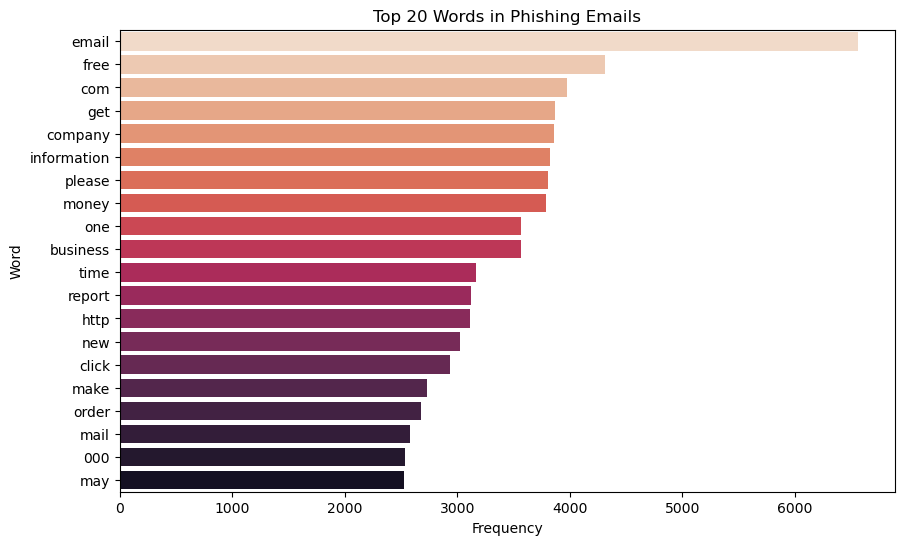

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_phishing_words, x='Frequency', y='Word', palette='rocket_r')
plt.title("Top 20 Words in Phishing Emails")
plt.show()

## Discussion Point: Does the word 'email' mean it shows up in all types of emails or is it present in the text of phishing emails. 

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

phishing_text = " ".join(df[df['email_type'] == 1]['clean_text'])
safe_text = " ".join(df[df['email_type'] == 0]['clean_text'])

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    #plt.show()
    plt.savefig(title)
    plt.close()

plot_wordcloud(phishing_text, "Word Cloud: Phishing Emails")
plot_wordcloud(safe_text, "Word Cloud: Safe Emails")

## Discussion: feature comparison between safe and phishing emails. 
As expected, low distribution for ohishing emails, they all have similar features. 

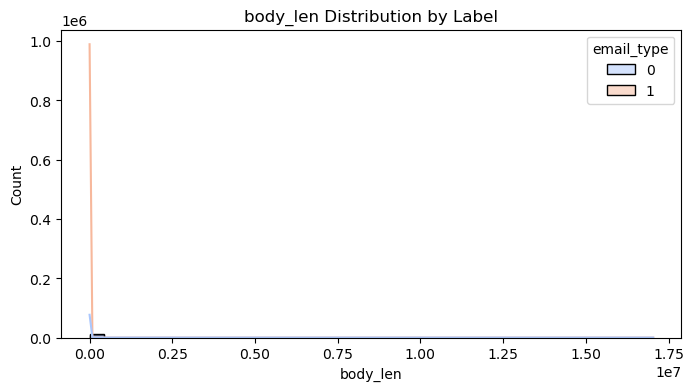

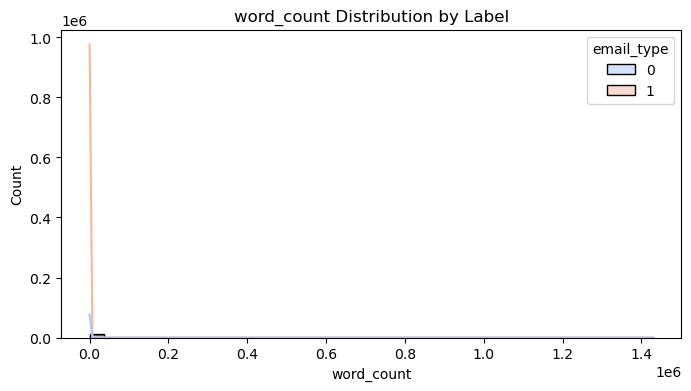

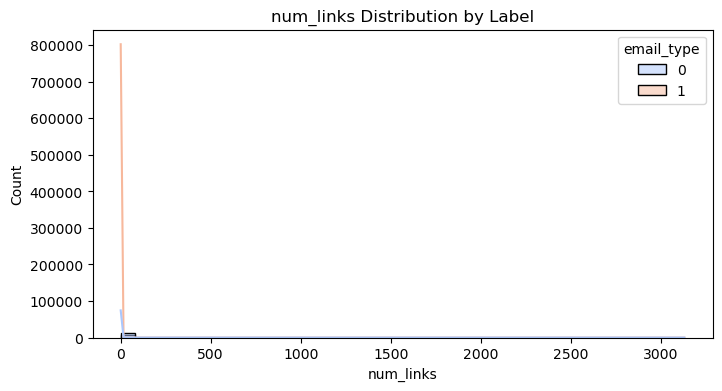

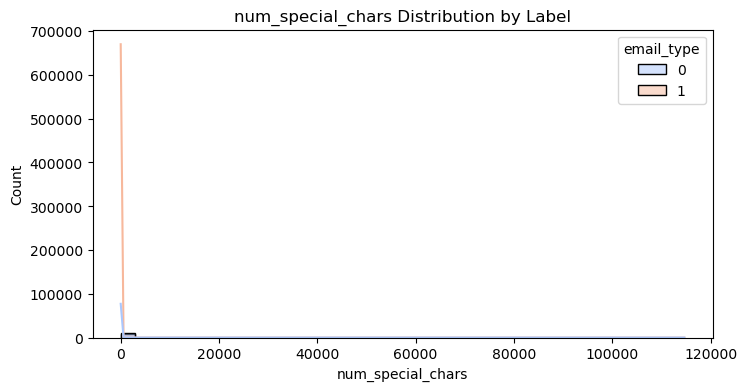

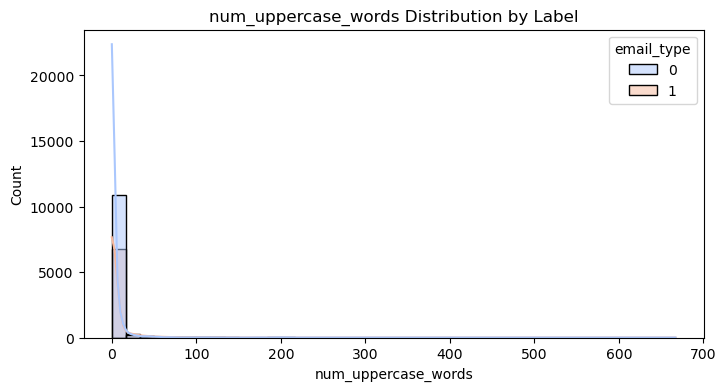

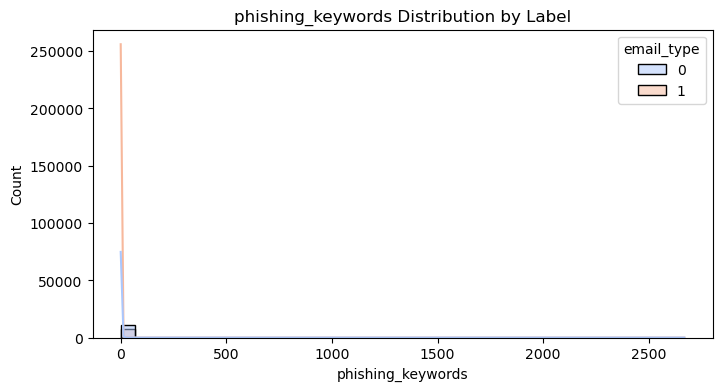

In [30]:
features = ['body_len', 'word_count', 'num_links', 'num_special_chars', 'num_uppercase_words', 'phishing_keywords']

for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=feature, hue='email_type', bins=40, kde=True, palette='coolwarm')
    plt.title(f"{feature} Distribution by Label")
    plt.show()

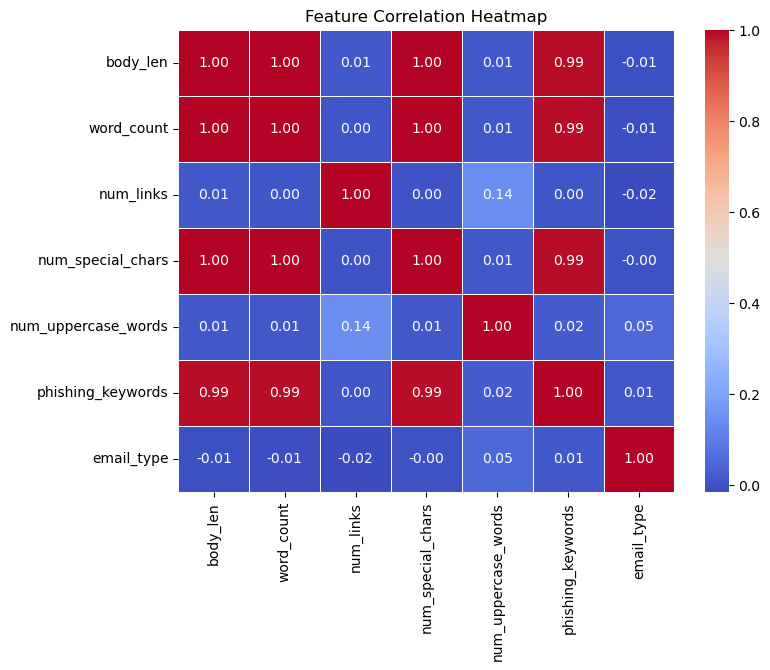

In [31]:
corr_features = df[features + ['email_type']]
corr_matrix = corr_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig("Feature_Correlation_Heatmap")
#plt.show()

## Predictive Model for Phishing Detection

In [32]:
y = df['email_type']
X_text = df['clean_text']  # vectorize this, not the raw text
X_features = df[['body_len', 'word_count', 'num_links', 'num_special_chars', 'num_uppercase_words', 'phishing_keywords']]

# Split
X_text_train, X_text_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    X_text, X_features, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000)
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)


In [34]:
from scipy.sparse import hstack
# Combine with other features
X_train_combined = hstack([X_text_train_tfidf, X_feat_train])
X_test_combined = hstack([X_text_test_tfidf, X_feat_test])

---------
## Random Forest Model

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_combined, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [36]:
# Predict
y_pred = clf.predict(X_test_combined)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2264
           1       0.93      0.97      0.95      1466

    accuracy                           0.96      3730
   macro avg       0.96      0.96      0.96      3730
weighted avg       0.96      0.96      0.96      3730



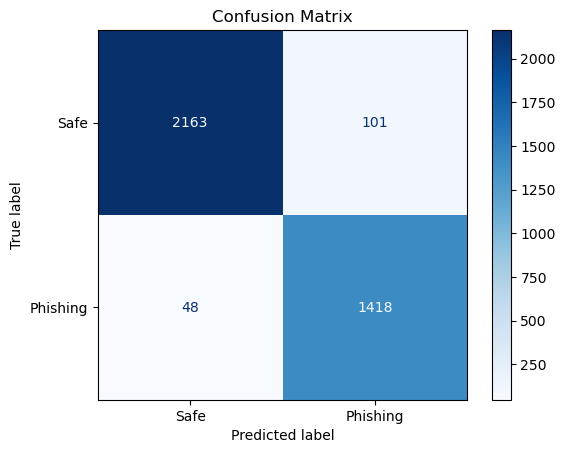

In [37]:
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Phishing"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Random Forest Feature Importance

In [38]:
# feature names: TF-IDF 
tfidf_features = vectorizer.get_feature_names_out()
all_feature_names = list(tfidf_features) + list(X_features.columns)

# importance ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20


/var/folders/70/06g525pn1dvcbpvss7dqvp6m0000gn/T/ipykernel_81191/196461961.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette='rocket_r')


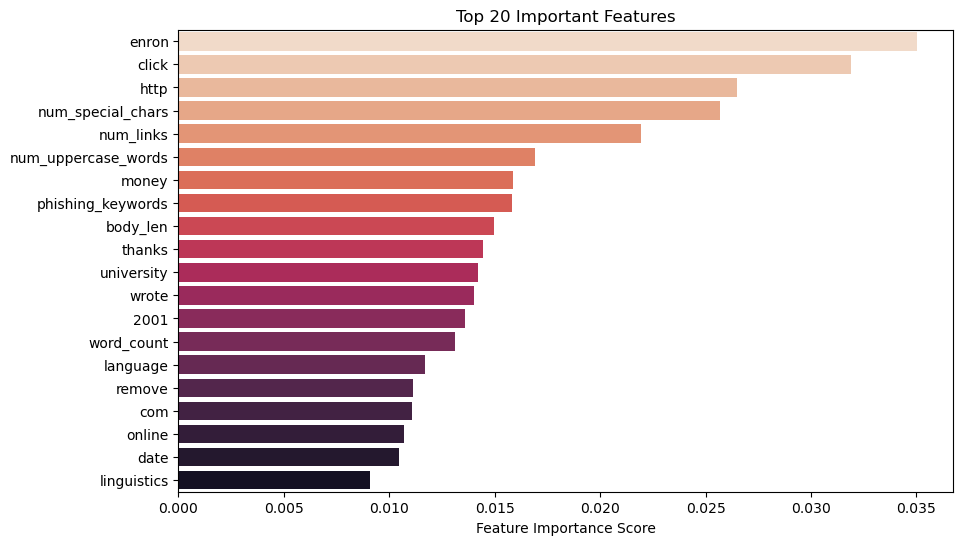

In [39]:
top_features = [all_feature_names[i] for i in indices]
top_scores = importances[indices]

plt.figure(figsize=(10,6))
sns.barplot(x=top_scores, y=top_features, palette='rocket_r')
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance Score")
plt.show()

## Discussion: Clearly Outdated data using a lot of 'enron' and '2001' in the text. This plot does show a marked difference from previous boxplot showing the feature importance has ranked more than just most common words/features.

---------
## Regression Model
Found issues with the solver (ConvergenceWarning) which is common when using Logistic Regression on sparse or high-dimensional datasets (ex:TF-IDF vectors). Means the solver hit the iteration cap before fully converging and neither a saga or coordinate descent solver fixed it therefore I am scaling the features. It turns out to be less precise than random forest model

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [67]:
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_test_scaled = scaler.transform(X_feat_test)

# Rebuild the combined feature sets
from scipy.sparse import hstack
X_train_combined = hstack([X_text_train_tfidf, X_feat_train_scaled])
X_test_combined = hstack([X_text_test_tfidf, X_feat_test_scaled])

In [68]:
# Predict
y_pred_logreg = logreg.predict(X_test_combined)


📄 Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2264
           1       0.94      0.83      0.88      1466

    accuracy                           0.91      3730
   macro avg       0.92      0.90      0.91      3730
weighted avg       0.92      0.91      0.91      3730



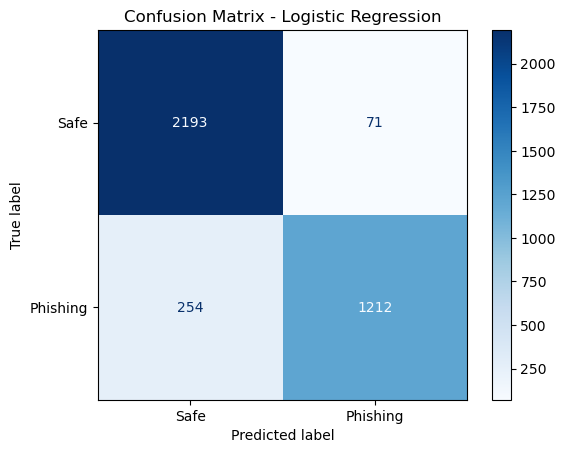

In [69]:
print("📄 Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_logreg)
ConfusionMatrixDisplay(cm_log, display_labels=["Safe", "Phishing"]).plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [70]:
tfidf_features = vectorizer.get_feature_names_out()
all_feature_names = list(tfidf_features) + list(X_features.columns)

coefs = logreg.coef_[0]
top_idx = np.argsort(np.abs(coefs))[::-1][:20]

top_features_log = [all_feature_names[i] for i in top_idx]
top_weights_log = coefs[top_idx]

/var/folders/70/06g525pn1dvcbpvss7dqvp6m0000gn/T/ipykernel_79382/3336321420.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights_log, y=top_features_log, palette='coolwarm')


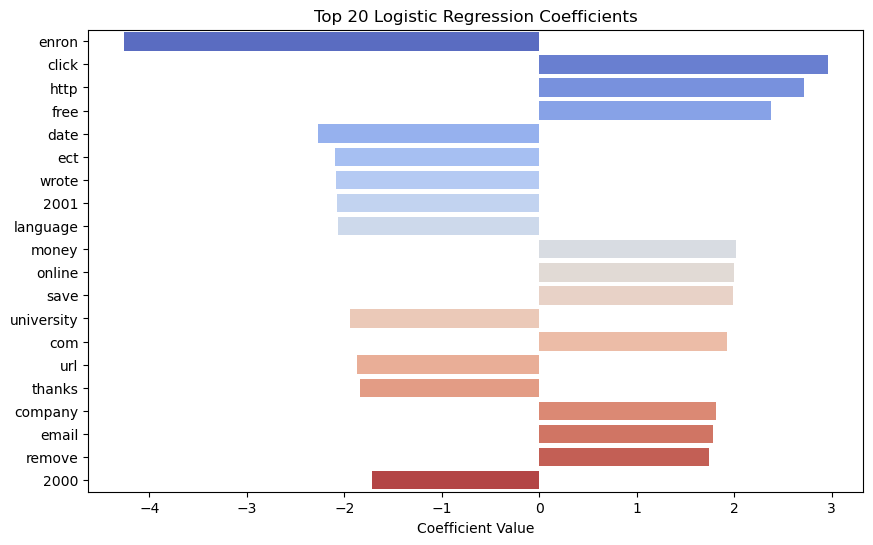

In [71]:
# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_weights_log, y=top_features_log, palette='coolwarm')
plt.title("Top 20 Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.show()

---------
## XGBoost Classifier

Now lets try XGboost to see if we can imprive on the previous two

In [40]:
from xgboost import XGBClassifier


In [41]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_combined, y_train)

y_pred_xgb = xgb.predict(X_test_combined)


📄 XGBoost Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2264
           1       0.93      0.96      0.94      1466

    accuracy                           0.96      3730
   macro avg       0.95      0.96      0.95      3730
weighted avg       0.96      0.96      0.96      3730



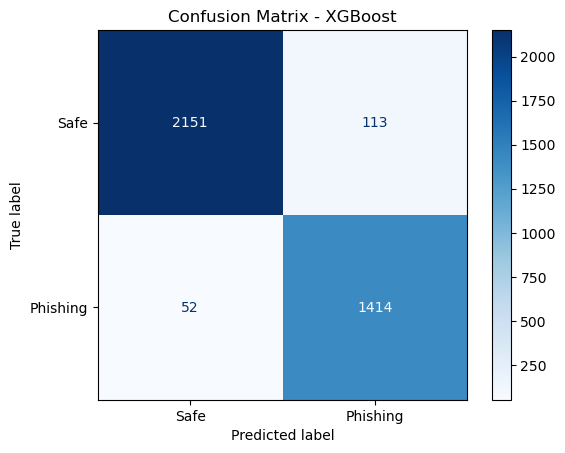

In [42]:
# Evaluation
print("📄 XGBoost Report:\n")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm_xgb, display_labels=["Safe", "Phishing"]).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [43]:
# Get top 20 feature importances
importances_xgb = xgb.feature_importances_
top_idx_xgb = np.argsort(importances_xgb)[::-1][:20]

top_features_xgb = [all_feature_names[i] for i in top_idx_xgb]
top_scores_xgb = importances_xgb[top_idx_xgb]


/var/folders/70/06g525pn1dvcbpvss7dqvp6m0000gn/T/ipykernel_81191/3423195068.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores_xgb, y=top_features_xgb, palette='mako_r')


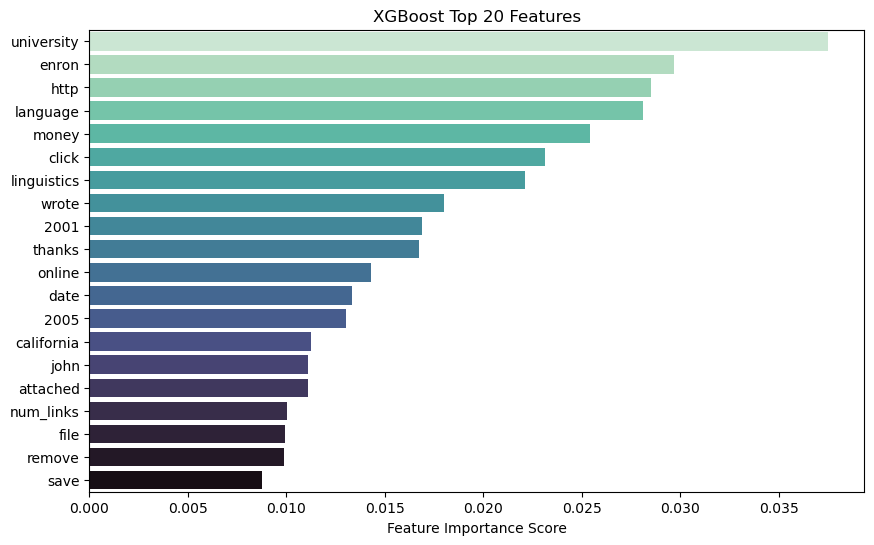

In [47]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_scores_xgb, y=top_features_xgb, palette='mako_r')
plt.title("XGBoost Top 20 Features")
plt.xlabel("Feature Importance Score")
plt.savefig("XGBoost_Top_20_Features")
#plt.show()


### Wordcloud that shows top features for both XGBOOST and RANDOM FOREST models

In [48]:
# Get all feature names
tfidf_features = vectorizer.get_feature_names_out()
all_feature_names = list(tfidf_features) + list(X_features.columns)

# Find index cutoff between TF-IDF and numeric
tfidf_len = len(tfidf_features)  

# Random Forest: 
rf_tfidf_importances = clf.feature_importances_[:tfidf_len]
rf_feature_weights = {word: score for word, score in zip(tfidf_features, rf_tfidf_importances)}

# XGBoost: 
xgb_tfidf_importances = xgb.feature_importances_[:tfidf_len]
xgb_feature_weights = {word: score for word, score in zip(tfidf_features, xgb_tfidf_importances)}

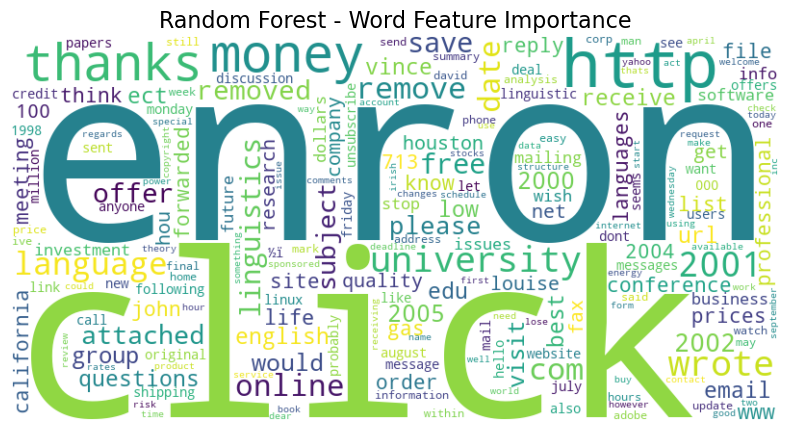

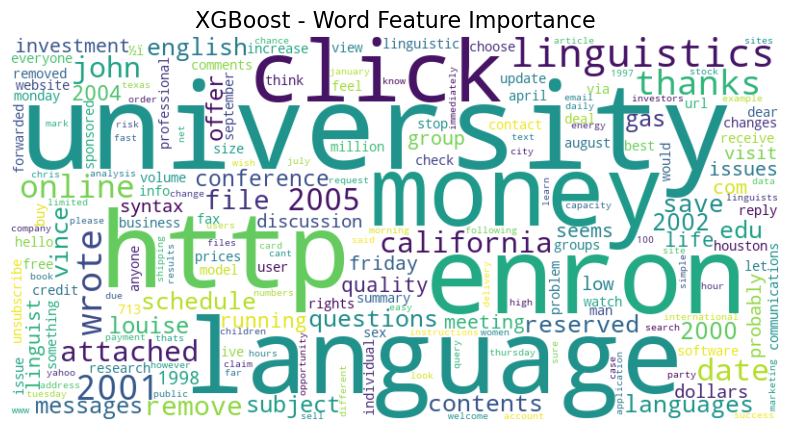

In [49]:
def plot_feature_wordcloud(feature_weights, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(feature_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Random Forest WordCloud
plot_feature_wordcloud(rf_feature_weights, "Random Forest - Word Feature Importance")

# XGBoost WordCloud
plot_feature_wordcloud(xgb_feature_weights, "XGBoost - Word Feature Importance")

---------
# Streanlit App preperation

Structure:
- app.py                    # Main
- phishing_model.pkl        # Trained model
- tfidf_vectorizer.pkl      # TF-IDF vectorizer
- phishing_emails.csv       # Data
  - wordcloud_rf.png etc...   # Pre-rendered WordClouds
  - featureimportance_xgb.png etc...


In [51]:
# Save models and vectorizer
import joblib

joblib.dump(clf, 'random_forest_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']

Edit red markdown text to change the streamlit app

In [53]:
code = '''
import streamlit as st
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Load models and vectorizer
rf_model = joblib.load('random_forest_model.pkl')
xgb_model = joblib.load('xgboost_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Set up aesthetic - straight up used chatgpt for this, how else is one to deal with HTML elements and colours?
st.set_page_config(page_title="Phishing Detector", layout="centered")
st.markdown("<h1 style='text-align: center; color: #0072B5;'>Phishing Email Detector</h1>", unsafe_allow_html=True)

# Sidebar
model_choice = st.sidebar.radio("Choose a model", ("Random Forest", "XGBoost"))

# Text input
user_input = st.text_area("Paste the email text here:")

if user_input:
    vectorized_input = vectorizer.transform([user_input])
    if model_choice == "Random Forest":
        prediction = rf_model.predict(vectorized_input)
    else:
        prediction = xgb_model.predict(vectorized_input)
    
    st.write("### Prediction:")
    st.success("Phishing Email" if prediction[0] == 1 else "Not a Phishing Email")

    # Wordcloud
    st.write("### Wordcloud of Your Email")
    wc = WordCloud(background_color='white', width=800, height=400).generate(user_input)
    fig, ax = plt.subplots()
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    st.pyplot(fig)
'''




with open("phishing_detector.py", "w") as f:
    f.write(code)